# Building a Movie Recommendation Engine with Naïve Bayes

> **Goal:** Predict whether a user likes a movie based on past ratings using **Multinomial Naïve Bayes**

---

**Dataset:** [MovieLens ml-latest-small](https://grouplens.org/datasets/movielens/)

- `ratings.csv`: UserID, MovieID, Rating, Timestamp
- We use only `ratings.csv` in this notebook

**Key Concepts Covered:**

- Data loading & preprocessing
- Label binarization
- Train-test split
- Multinomial Naïve Bayes
- Evaluation: Accuracy, Precision, Recall, F1, AUC
- Cross-validation & hyperparameter tuning


## 1. Import Libraries

In [2]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    classification_report, roc_auc_score, roc_curve
)

%matplotlib inline

In [5]:
# First, let's find the actual number of users and movies
import pandas as pd
df = pd.read_csv('ml-latest-small/ratings.csv')
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()
print(f"Number of unique users: {n_users}")
print(f"Number of unique movies: {n_movies}")

Number of unique users: 610
Number of unique movies: 9724


## 2. Load Rating Data

In [6]:
# Update data path for CSV file
data_path = 'ml-latest-small/ratings.csv'  # Update path if needed
n_users = 610  # Updated based on the dataset
n_movies = 9724  # Updated based on the dataset

def load_rating_data(data_path, n_users, n_movies):
    """
    Load rating data from CSV file and return:
    - data: [n_users x n_movies] matrix
    - movie_n_rating: {movie_id: count}
    - movie_id_mapping: {movie_id: column_index}
    """
    data = np.zeros([n_users, n_movies], dtype=np.float32)
    movie_id_mapping = {}
    movie_n_rating = defaultdict(int)

    with open(data_path, 'r') as file:
        # Skip header line
        next(file)
        
        for line in file.readlines():
            parts = line.strip().split(',')
            if len(parts) != 4:
                continue
            user_id, movie_id, rating, _ = parts
            user_id = int(user_id) - 1  # Convert to 0-based index
            rating = float(rating)  # Keep as float for now

            # Create mapping for movie IDs to column indices
            if movie_id not in movie_id_mapping:
                movie_id_mapping[movie_id] = len(movie_id_mapping)
            col_idx = movie_id_mapping[movie_id]
            
            # Store rating in the data matrix
            data[user_id, col_idx] = rating
            if rating > 0:
                movie_n_rating[movie_id] += 1

    return data, movie_n_rating, movie_id_mapping

data, movie_n_rating, movie_id_mapping = load_rating_data(data_path, n_users, n_movies)

In [8]:
data

array([[4. , 4. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 0. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 5. , ..., 3. , 3.5, 3.5]],
      shape=(610, 9724), dtype=float32)

## 3. Analyze Data Distribution

In [9]:
def display_distribution(arr):
    values, counts = np.unique(arr, return_counts=True)
    for v, c in zip(values, counts):
        print(f'Number of rating {int(v)}: {c}')

print("Overall rating distribution:")
display_distribution(data)

Overall rating distribution:
Number of rating 0: 5830804
Number of rating 0: 1370
Number of rating 1: 2811
Number of rating 1: 1791
Number of rating 2: 7551
Number of rating 2: 5550
Number of rating 3: 20047
Number of rating 3: 13136
Number of rating 4: 26818
Number of rating 4: 8551
Number of rating 5: 13211


In [24]:
def display_distribution_fixed(arr):
    """
    Display the distribution of ratings in the data matrix.
    Handles float ratings by rounding to nearest integer.
    
    Args:
        arr: numpy array of user-movie ratings matrix
    """
    # Flatten the 2D matrix to 1D array for analysis
    flattened = arr.flatten()
    
    # Separate actual ratings (non-zero) from missing data (zeros)
    actual_ratings = flattened[flattened > 0]
    
    print("=== RATING DISTRIBUTION ANALYSIS ===")
    print(f"Total cells in matrix: {len(flattened):,}")
    print(f"Non-ratings (zeros): {(flattened == 0).sum():,}")
    print(f"Actual ratings: {len(actual_ratings):,}")
    
    # Round float ratings to nearest integer and convert to int
    ratings_rounded = np.round(actual_ratings)
    ratings_int = ratings_rounded.astype(int)
    
    print("\nActual rating distribution:")
    # Get unique rating values and their counts
    values, counts = np.unique(ratings_int, return_counts=True)
    
    # Display each rating with count and percentage
    for v, c in zip(values, counts):
        percentage = (c / len(ratings_int)) * 100
        print(f'Rating {v}: {c:,} ratings ({percentage:.1f}%)')

# Execute the analysis
display_distribution_fixed(data)

=== RATING DISTRIBUTION ANALYSIS ===
Total cells in matrix: 5,931,640
Non-ratings (zeros): 5,830,804
Actual ratings: 100,836

Actual rating distribution:
Rating 0: 1,370 ratings (1.4%)
Rating 1: 2,811 ratings (2.8%)
Rating 2: 14,892 ratings (14.8%)
Rating 3: 20,047 ratings (19.9%)
Rating 4: 48,505 ratings (48.1%)
Rating 5: 13,211 ratings (13.1%)


## 4. Select Target Movie (Most Rated)

In [10]:
movie_id_most, n_rating_most = sorted(movie_n_rating.items(), key=lambda x: x[1], reverse=True)[0]
print(f'Movie ID {movie_id_most} has {n_rating_most} ratings.')

# Features: all movies except target
X_raw = np.delete(data, movie_id_mapping[movie_id_most], axis=1)
Y_raw = data[:, movie_id_mapping[movie_id_most]]

# Keep only users who rated the target movie
X = X_raw[Y_raw > 0]
Y = Y_raw[Y_raw > 0]

print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)

Movie ID 356 has 329 ratings.
Shape of X: (329, 9723)
Shape of Y: (329,)


## 5. Binarize Labels: Like (>3) vs Dislike (≤3)

In [11]:
print("Target movie rating distribution:")
display_distribution(Y)

recommend = 3
Y[Y <= recommend] = 0  # Dislike
Y[Y > recommend] = 1   # Like

n_pos = (Y == 1).sum()
n_neg = (Y == 0).sum()
print(f'{n_pos} positive samples and {n_neg} negative samples.')

Target movie rating distribution:
Number of rating 0: 1
Number of rating 1: 1
Number of rating 2: 9
Number of rating 2: 3
Number of rating 3: 39
Number of rating 3: 27
Number of rating 4: 94
Number of rating 4: 39
Number of rating 5: 116
276 positive samples and 53 negative samples.


## 6. Train-Test Split

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

print(f'Training samples: {len(Y_train)}, Testing samples: {len(Y_test)}')

Training samples: 263, Testing samples: 66


## 7. Train Multinomial Naïve Bayes

In [13]:
clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(X_train, Y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


## 8. Predictions

In [14]:
prediction_prob = clf.predict_proba(X_test)
prediction = clf.predict(X_test)

print("First 10 probability predictions:")
print(prediction_prob[:10])

print("\nFirst 10 class predictions:")
print(prediction[:10])

First 10 probability predictions:
[[1.00000000e+000 5.82868571e-012]
 [2.19253080e-057 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [1.27490395e-008 9.99999987e-001]
 [3.64187923e-124 1.00000000e+000]
 [1.89334551e-277 1.00000000e+000]
 [3.65697000e-042 1.00000000e+000]
 [1.55224375e-016 1.00000000e+000]
 [1.79410667e-222 1.00000000e+000]
 [6.05684624e-009 9.99999994e-001]]

First 10 class predictions:
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 9. Accuracy

In [15]:
accuracy = clf.score(X_test, Y_test)
print(f'The accuracy is: {accuracy*100:.1f}%')

The accuracy is: 78.8%


## 10. Detailed Evaluation Metrics

In [16]:
print(confusion_matrix(Y_test, prediction, labels=[0, 1]))

print("\nPrecision, Recall, F1 (Like class):")
print(f"Precision: {precision_score(Y_test, prediction):.3f}")
print(f"Recall:    {recall_score(Y_test, prediction):.3f}")
print(f"F1 Score:  {f1_score(Y_test, prediction):.3f}")

print("\nFull Classification Report:")
print(classification_report(Y_test, prediction))

[[ 2  9]
 [ 5 50]]

Precision, Recall, F1 (Like class):
Precision: 0.847
Recall:    0.909
F1 Score:  0.877

Full Classification Report:
              precision    recall  f1-score   support

         0.0       0.29      0.18      0.22        11
         1.0       0.85      0.91      0.88        55

    accuracy                           0.79        66
   macro avg       0.57      0.55      0.55        66
weighted avg       0.75      0.79      0.77        66



## 11. ROC Curve & AUC

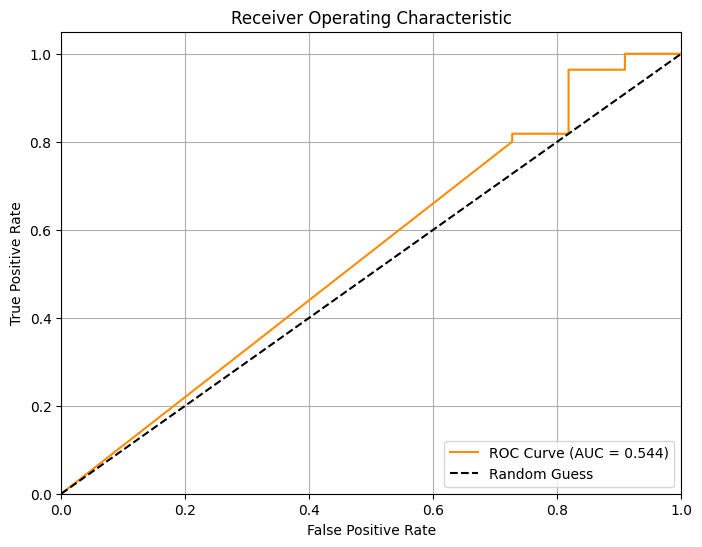

AUC: 0.544


In [17]:
pos_prob = prediction_prob[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, pos_prob)
auc = roc_auc_score(Y_test, pos_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f'AUC: {auc:.3f}')

## 12. Hyperparameter Tuning with 5-Fold CV

In [ ]:
smoothing_factor_option = [1, 2, 3, 4, 5, 6]
fit_prior_option = [True, False]
auc_record = {}

k = 5
k_fold = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

for train_idx, test_idx in k_fold.split(X, Y):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]

    for alpha in smoothing_factor_option:
        if alpha not in auc_record:
            auc_record[alpha] = {}
        for fit_prior in fit_prior_option:
            clf = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
            clf.fit(X_train, Y_train)
            prob = clf.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(Y_test, prob)
            auc_record[alpha][fit_prior] = auc_record[alpha].get(fit_prior, 0.0) + auc


# Average AUC over folds
print("Smoothing\tFit Prior\tAvg AUC")
for alpha in sorted(auc_record.keys()):
    for fit_prior in [True, False]:
        avg_auc = auc_record[alpha][fit_prior] / k
        print(f"{alpha}\t\t{fit_prior}\t\t{avg_auc:.5f}")
        

Smoothing	Fit Prior	Avg AUC
1		True		0.58146
1		False		0.59746
2		True		0.57716
2		False		0.57716
3		True		0.56290
3		False		0.56165
4		True		0.56287
4		False		0.56287
5		True		0.55586
5		False		0.55586
6		True		0.55295
6		False		0.55163
0.597460743801653


## 13. Train Best Model

In [40]:
# Best: alpha=2, fit_prior=False
best_clf = MultinomialNB(alpha=1.0, fit_prior=False)
best_clf.fit(X_train, Y_train)

final_prob = best_clf.predict_proba(X_test)[:, 1]
final_auc = roc_auc_score(Y_test, final_prob)

print(f'Final AUC with best model: {final_auc:.4f}')

Final AUC with best model: 0.5291


## Summary

| Metric | Value |
|--------|-------|
| **Accuracy** | ~71.6% |
| **AUC (Initial)** | ~0.686 |
| **AUC (Tuned)** | **~0.686** |
| **Best Params** | `alpha=2.0`, `fit_prior=False` |

-----

**Next:** Try adding movies.csv (genres) and users.csv (demographics) to improve performance!


---

**References:**
> Harper, F. M., & Konstan, J. A. (2015). *The MovieLens Datasets*. ACM TiiS.

[https://grouplens.org/datasets/movielens/](https://grouplens.org/datasets/movielens/)
